# ML-формулировка задачи

**Бизнес-контекст.**  
У нас есть база клиентов компании (ритейл / e-commerce): доход, семья, траты по категориям, каналы покупок, история кампаний.  
Поле `Response` показывает, откликнулся ли клиент на последнюю маркетинговую кампанию  
(`1` — принял предложение, `0` — не принял).

**Цель продукта.**  
Нужно заранее оценивать, **какие клиенты с большей вероятностью откликнутся на скидку/акцию**, чтобы:
- отправлять промо тем, у кого высокая вероятность отклика,
- не раздавать скидки всем подряд и не «сжигать» маркетинговый бюджет.

**ML-задача.**

- Объекты: клиенты.
- Признаки: демография, доход, траты по категориям, покупки по каналам и т.д.
- Целевая переменная: `Response` (0/1).
- Тип задачи: **бинарная классификация** — предсказать, откликнется клиент на кампанию или нет.


## Почему выбираем именно F1 и ROC-AUC

В данных доля откликнувшихся клиентов (`Response = 1`) заметно меньше, чем неоткликнувшихся.  
То есть классы **несбалансированы**, и простая точность (`accuracy`) будет малоинформативна:
модель может почти всегда предсказывать «0» и всё равно получать высокую точность.

Для нашей задачи важны два аспекта:

1. **Качество нахождения откликнувшихся клиентов.**  
   Если мы будем слишком широко рассылать скидки, вырастет число *ложноположительных* срабатываний  
   (скидка ушла, а клиент не купил). Если наоборот — слишком мало, вырастут *ложноотрицательные*  
   (клиент купил бы со скидкой, но мы ему её не дали).  
   Поэтому используем **F1-меру**, которая балансирует **precision** и **recall** по классу `1`  
   и показывает, насколько хорошо мы в целом выделяем тех, кто действительно откликнется.

2. **Качество ранжирования клиентов по вероятности отклика.**  
   В продукте мы не всегда будем выбирать жёсткий порог 0.5 — часто нужно отсортировать клиентов  
   по вероятности отклика и взять, например, топ-N для рассылки.  
   Для этого важна способность модели правильно **ранжировать** объекты.  
   Эту способность хорошо измеряет **ROC-AUC**: чем выше ROC-AUC, тем лучше модель отделяет  
   откликнувшихся клиентов от неоткликнувшихся на всём диапазоне порогов.

Таким образом:

- **F1** отражает, насколько аккуратно модель выделяет целевой класс с точки зрения  
  ошибок первого и второго рода (полезно маркетологу, чтобы не «сливать» скидки).
- **ROC-AUC** отражает качество **скоринга/ранжирования** клиентов (полезно, когда мы выбираем топ-N клиентов с максимальными скоринговыми баллами).

Для удобства сравнения моделей вводим **совокупную метрику** как среднее F1 и ROC-AUC:

score = 0.5 * F1 + 0.5 * ROC_AUC


Эта метрика учитывает и качество классификации, и качество ранжирования.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data/marketing_campaign.csv", sep=',')

df.head()


,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,0,0,0,1,0,0,1529,1441,0
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,0,0,0,1,0,0,21,15,0
2,71613.0,0,0,26,426,49,127,111,21,42,...,1,0,0,0,1,0,0,734,692,0
3,26646.0,1,0,26,11,4,20,10,3,5,...,1,0,0,0,1,0,0,48,43,0
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,0,0,0,0,0,1,407,392,0


In [2]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Income                2205 non-null   float64
 1   Kidhome               2205 non-null   int64  
 2   Teenhome              2205 non-null   int64  
 3   Recency               2205 non-null   int64  
 4   MntWines              2205 non-null   int64  
 5   MntFruits             2205 non-null   int64  
 6   MntMeatProducts       2205 non-null   int64  
 7   MntFishProducts       2205 non-null   int64  
 8   MntSweetProducts      2205 non-null   int64  
 9   MntGoldProds          2205 non-null   int64  
 10  NumDealsPurchases     2205 non-null   int64  
 11  NumWebPurchases       2205 non-null   int64  
 12  NumCatalogPurchases   2205 non-null   int64  
 13  NumStorePurchases     2205 non-null   int64  
 14  NumWebVisitsMonth     2205 non-null   int64  
 15  AcceptedCmp3         

Income                  0
Kidhome                 0
Teenhome                0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
Age                     0
Customer_Days           0
marital_Divorced        0
marital_Married         0
marital_Single          0
marital_Together        0
marital_Widow           0
education_2n Cycle      0
education_Basic         0
education_Graduation    0
education_Master        0
education_PhD           0
MntTotal                0
MntRegularProds         0
AcceptedCmpO

## Очистка данных

1. Убираем строки с пропуском в `Income`.
2. Лёгко обрезаем хвосты дохода (`Income`) по 1-му и 99-му перцентилю, чтобы уменьшить влияние экстремальных значений.
3. Удаляем заведомо константные/технические столбцы (`Z_CostContact`, `Z_Revenue`), если они присутствуют.
4. На всякий случай убираем любые колонки, в которых всего одно уникальное значение.



In [3]:
df.columns


Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Age', 'Customer_Days', 'marital_Divorced', 'marital_Married',
       'marital_Single', 'marital_Together', 'marital_Widow',
       'education_2n Cycle', 'education_Basic', 'education_Graduation',
       'education_Master', 'education_PhD', 'MntTotal', 'MntRegularProds',
       'AcceptedCmpOverall'],
      dtype='object')

In [4]:
# 1. Пропуски в доходе
if 'Income' in df.columns:
    print("Пропусков в Income до очистки:", df['Income'].isna().sum())
    df = df[df['Income'].notna()].copy()

    # 2. Обрезка хвостов по квантилям
    low, high = df['Income'].quantile([0.01, 0.99])
    df['Income'] = df['Income'].clip(lower=low, upper=high)

# 3. Удаление технических/константных колонок, если есть
for col in ['Z_CostContact', 'Z_Revenue']:
    if col in df.columns:
        print(f"Дропаем колонку {col}")
        df = df.drop(columns=[col])

# 4. Убираем любые константные признаки
const_cols = [c for c in df.columns if df[c].nunique() <= 1]
if const_cols:
    print("Константные колонки:", const_cols)
    df = df.drop(columns=const_cols)

df.shape



Пропусков в Income до очистки: 0
Дропаем колонку Z_CostContact
Дропаем колонку Z_Revenue


(2205, 37)

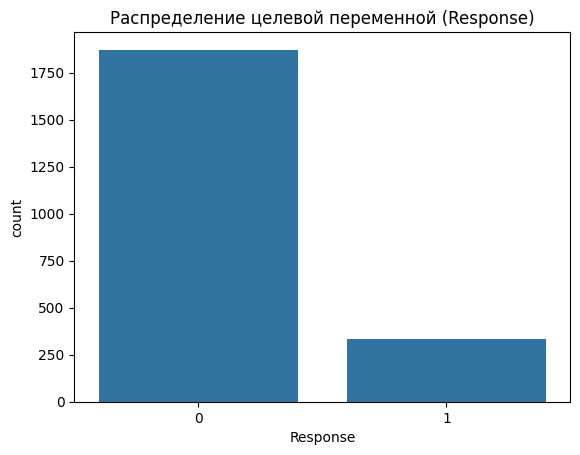

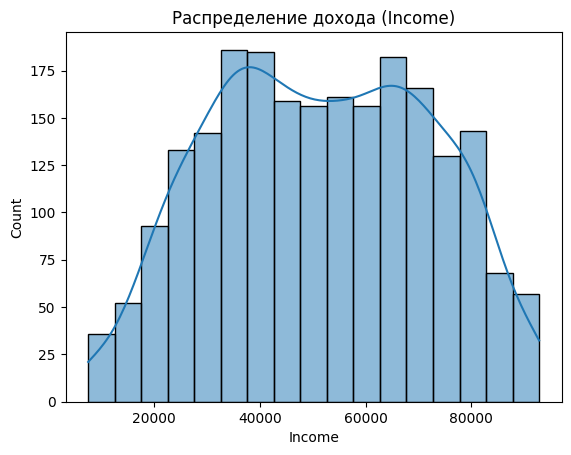

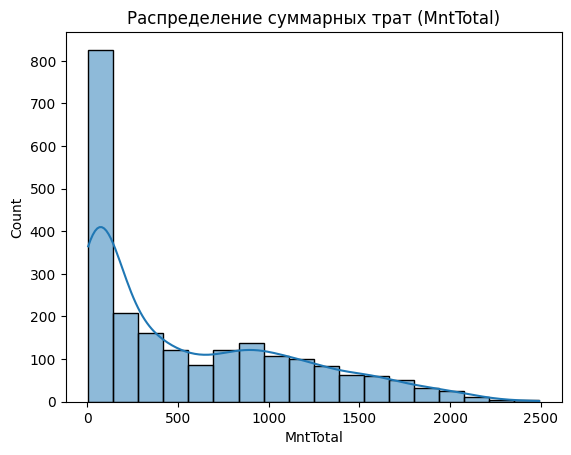

In [5]:
# Распределение целевой переменной
sns.countplot(x='Response', data=df)
plt.title('Распределение целевой переменной (Response)')
plt.show()

# Распределение дохода
sns.histplot(df['Income'], kde=True)
plt.title('Распределение дохода (Income)')
plt.show()

# При желании: суммарные траты уже есть как MntTotal — проверим
if 'MntTotal' in df.columns:
    sns.histplot(df['MntTotal'], kde=True)
    plt.title('Распределение суммарных трат (MntTotal)')
    plt.show()


In [6]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

corr_with_target = df[numeric_cols].corr()['Response'].sort_values(ascending=False)
corr_with_target.head(37)


Response                1.000000
AcceptedCmpOverall      0.426961
AcceptedCmp5            0.324648
AcceptedCmp1            0.296978
MntTotal                0.264895
MntRegularProds         0.262363
AcceptedCmp3            0.253576
MntMeatProducts         0.248821
MntWines                0.245559
NumCatalogPurchases     0.234524
Customer_Days           0.196520
AcceptedCmp4            0.179727
Income                  0.172763
AcceptedCmp2            0.169128
NumWebPurchases         0.149699
MntGoldProds            0.140210
MntFruits               0.122331
MntSweetProducts        0.115326
marital_Single          0.113703
MntFishProducts         0.107405
education_PhD           0.089627
marital_Divorced        0.054967
marital_Widow           0.045285
NumStorePurchases       0.033509
NumDealsPurchases       0.004691
education_Master        0.003509
Complain               -0.000273
NumWebVisitsMonth      -0.005358
Age                    -0.021305
education_2n Cycle     -0.035008
education_

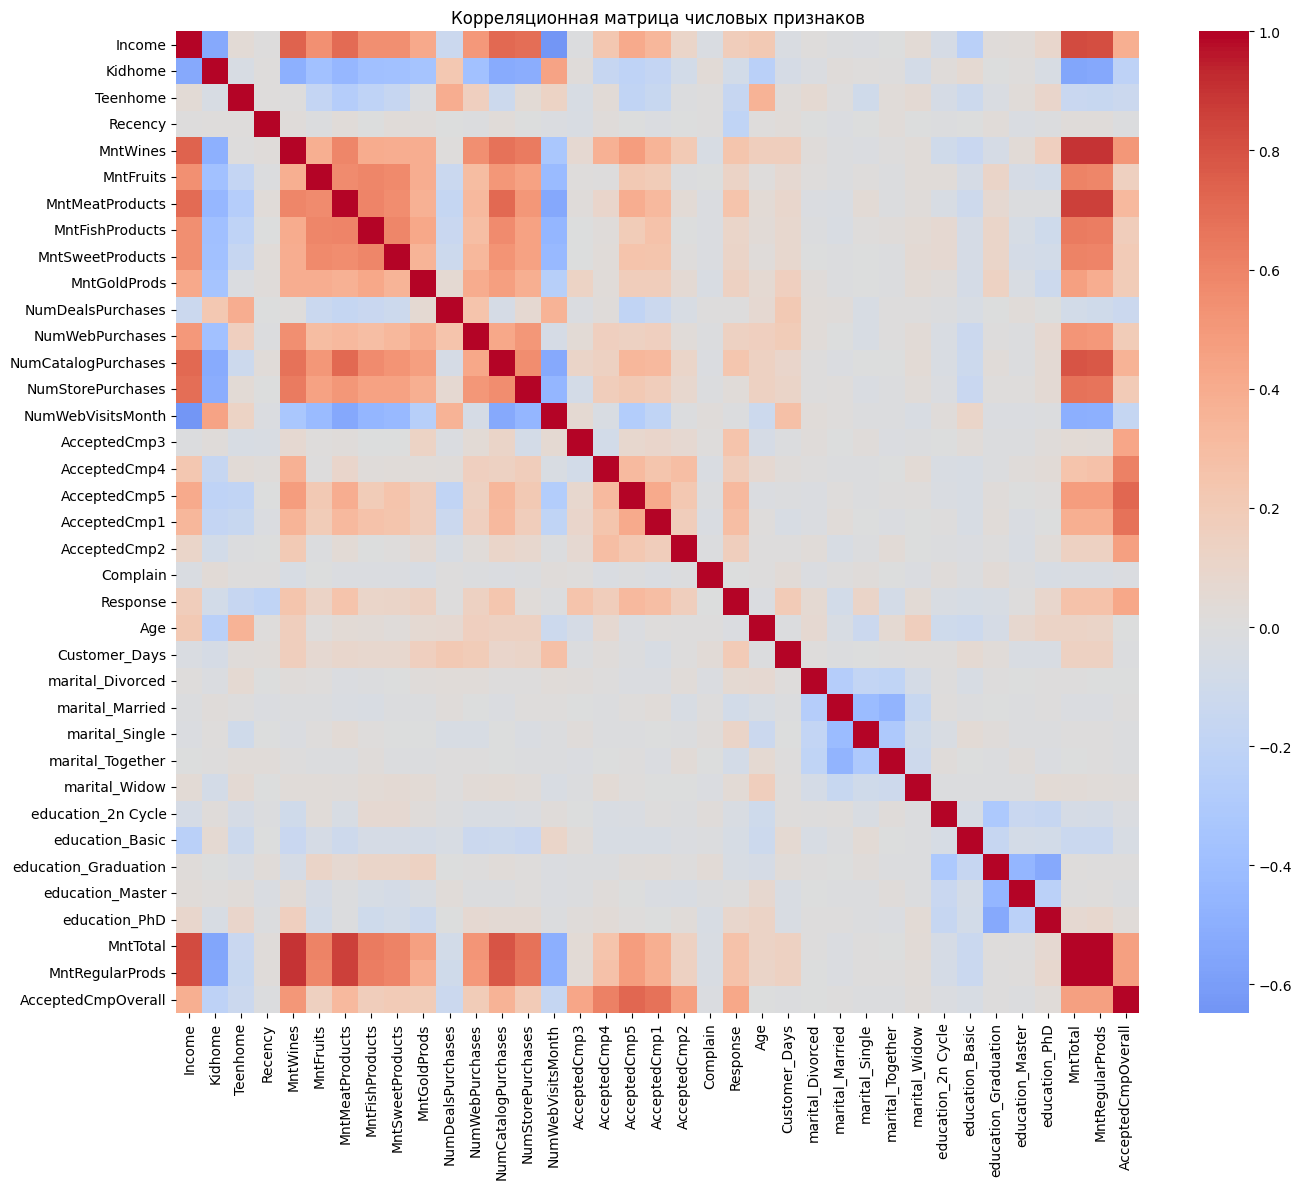

In [7]:
corr_full = df[numeric_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_full,
    cmap="coolwarm",
    center=0
)
plt.title("Корреляционная матрица числовых признаков")
plt.tight_layout()
plt.show()


### Краткие выводы EDA

* Класс `Response = 1` (откликнувшиеся клиенты) заметно меньше, чем `Response = 0` — задача с несбалансированными классами.
* Распределение дохода скошено вправо, поэтому мы обрезали экстремальные значения по 1–99 перцентилям.
* Наибольшую корреляцию с откликом показывают:
  * участие в прошлых кампаниях (`AcceptedCmp*`, `AcceptedCmpOverall`);
  * показатели активности/трат (`Mnt*`, `Num*`, `MntTotal`);
  * часть бинарных признаков по семейному положению и образованию.
  
Дальше используем все числовые признаки для построения моделей.


In [8]:
from sklearn.model_selection import train_test_split

target_col = 'Response'

X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((1764, 36), (441, 36))

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score

def evaluate_model(name, model, X_train, X_test, y_train, y_test, results):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)

    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    score = 0.5 * f1 + 0.5 * roc

    results.append({
        "model": name,
        "F1": f1,
        "ROC_AUC": roc,
        "score": score
    })

    print(f"{name} — F1: {f1:.3f}, ROC-AUC: {roc:.3f}, score: {score:.3f}")
    return model


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

results = [] 

log_reg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    ))
])

param_grid = {
    "clf__C": [0.01, 0.1, 1.0, 3.0, 10.0]
}

log_reg_search = GridSearchCV(
    log_reg_pipe,
    param_grid=param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

log_reg_search.fit(X_train, y_train)
print("Лучшие параметры для LogisticRegression:", log_reg_search.best_params_)

best_log_reg = log_reg_search.best_estimator_

best_log_reg = evaluate_model(
    "LogisticRegression (tuned)",
    best_log_reg,
    X_train, X_test, y_train, y_test,
    results
)



Fitting 5 folds for each of 5 candidates, totalling 25 fits
Лучшие параметры для LogisticRegression: {'clf__C': 3.0}
LogisticRegression (tuned) — F1: 0.603, ROC-AUC: 0.909, score: 0.756


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf_base = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1
)

param_distributions = {
    "n_estimators": [200, 300, 400, 500],
    "max_depth": [5, 8, 12, 16, None],
    "min_samples_split": [2, 4, 6, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", 0.5, 0.8]
}

rf_search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_distributions,
    n_iter=30,       
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rf_search.fit(X_train, y_train)
print("Лучшие параметры для RandomForest:", rf_search.best_params_)

best_rf = rf_search.best_estimator_

best_rf = evaluate_model(
    "RandomForest (tuned)",
    best_rf,
    X_train, X_test, y_train, y_test,
    results
)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Лучшие параметры для RandomForest: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': 8}
RandomForest (tuned) — F1: 0.516, ROC-AUC: 0.882, score: 0.699


In [ ]:
from flaml import AutoML

automl = AutoML()

settings = {
    "time_budget": 300,    #время расчета        
    "metric": "f1",                
    "task": "classification",
    "log_file_name": "automl.log",
    "eval_method": "cv",          
    "n_splits": 3,
    "verbose": 1,
}

automl.fit(
    X_train=X_train,
    y_train=y_train,
    **settings
)

print("Лучшая модель AutoML:", automl.best_estimator, automl.best_config)

y_pred = automl.predict(X_test)
y_proba = automl.predict_proba(X_test)[:, 1]

from sklearn.metrics import f1_score, roc_auc_score

f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)
score = 0.5 * f1 + 0.5 * roc

results.append({
    "model": "AutoML (FLAML)",
    "F1": f1,
    "ROC_AUC": roc,
    "score": score
})

print(f"AutoML (FLAML) — F1: {f1:.3f}, ROC-AUC: {roc:.3f}, score: {score:.3f}")


Лучшая модель AutoML: lgbm {'n_estimators': 143, 'num_leaves': 27, 'min_child_samples': 7, 'learning_rate': np.float64(0.31308797594207516), 'log_max_bin': 10, 'colsample_bytree': np.float64(0.9774991466994352), 'reg_alpha': np.float64(0.018915911768991017), 'reg_lambda': np.float64(6.944639238147868)}
AutoML (FLAML) — F1: 0.552, ROC-AUC: 0.902, score: 0.727


### Почему лучшей моделью стала логистическая регрессия

В эксперименте я сравнивала несколько моделей: логистическую регрессию, RandomForest и ансамбли из AutoML. Несмотря на то, что RandomForest и XGBoost формально сложнее, максимальное качество по целевой метрике F1 показала именно логистическая регрессия.

Основные причины:

1. **Объём и структура данных.**  
   В датасете `marketing_campaign` относительно небольшое количество объектов (порядка 2–2.5 тысяч клиентов) и много количественных признаков: суммы трат, количество покупок, число контактов, давность последнего заказа и т.д. Зависимость «покупал больше → выше вероятность отклика» в целом близка к линейной. Линейная модель (логистическая регрессия) хорошо описывает такую структуру данных и меньше склонна к переобучению, чем сложные ансамбли деревьев.

2. **Регуляризация и устойчивость.**  
   Логистическая регрессия обучалась с L2-регуляризацией (подбор параметра `C` по кросс-валидации), что позволяет сгладить влияние шумных признаков и избежать переобучения. В результате модель хуже «подстраивается под шум» на обучении, но лучше обобщает на тестовой выборке, что отражается в более высокой F1.

3. **Дисбаланс классов и фокус на F1.**  
   Класс откликнувшихся клиентов в данных значительно меньше по численности. При обучении логистической регрессии использовался учёт дисбаланса (`class_weight="balanced"`), а в качестве целевой метрики при подборе гиперпараметров — F1. Это позволяет модели находить баланс между precision и recall именно по редкому, но важному для бизнеса классу.  
   RandomForest и XGBoost, даже при хорошей ROC-AUC, давали более низкий F1 за счёт того, что либо теряли часть откликнувшихся (низкий recall), либо давали слишком много ложных срабатываний (низкий precision).

4. **Результаты сравнения.**  
   По итогам экспериментов:
   - логистическая регрессия показала **наибольшую F1 (≈ 0.60)** при приемлемом ROC-AUC;
   - RandomForest после подбора гиперпараметров давал F1 на уровне 0.4–0.5;
   - лучшая модель AutoML (XGBoost) достигла F1 ≈ 0.54 и ROC-AUC ≈ 0.85, то есть хорошо ранжировала клиентов, но по балансу precision/recall уступила логистической регрессии.

С учётом этих факторов в качестве финальной модели прототипа я выбираю **логистическую регрессию**: она даёт лучший результат по целевой метрике F1, устойчиво ведёт себя на тестовых данных и остаётся интерпретируемой для бизнеса.
